In [ ]:
"""
Insurance Claims Loss Ratio Monitoring Project

Objective:
- Monitor Loss Ratio (Claims / Premium)
- Track Customer Success KPIs (CSAT, NPS, FCR)
- Detect Anomalies (Loss ratio spikes)
- Generate Monthly KPI Reports
"""


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("insurance_loss_ratio_dataset.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (30000, 12)


,policy_id,date,policy_type,region,channel,premium_amount,claim_amount,csat_score,nps_score,fcr_flag,ticket_resolution_hrs,loss_ratio
0,1,2023-12-15,Health,North,Agent,11192.76,4520.44,4.6,66,1,3.7,0.404
1,2,2023-05-07,Life,North,Agent,5786.72,1430.24,3.4,-36,1,0.6,0.247
2,3,2023-02-26,Health,East,Direct,17540.33,1757.59,3.7,-22,1,22.3,0.100
3,4,2023-09-09,Life,North,Agent,8166.84,1217.79,4.1,-9,1,23.2,0.149
4,5,2023-05-06,Home,North,Partner,31641.87,639.35,3.5,72,1,4.3,0.020


In [4]:
df["date"] = pd.to_datetime(df["date"])

# Calculate Loss Ratio
df["loss_ratio"] = df["claim_amount"] / df["premium_amount"]

# High Risk Flag
df["high_risk_flag"] = df["loss_ratio"].apply(lambda x: 1 if x > 0.8 else 0)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   policy_id              30000 non-null  int64         
 1   date                   30000 non-null  datetime64[ns]
 2   policy_type            30000 non-null  object        
 3   region                 30000 non-null  object        
 4   channel                30000 non-null  object        
 5   premium_amount         30000 non-null  float64       
 6   claim_amount           30000 non-null  float64       
 7   csat_score             30000 non-null  float64       
 8   nps_score              30000 non-null  int64         
 9   fcr_flag               30000 non-null  int64         
 10  ticket_resolution_hrs  30000 non-null  float64       
 11  loss_ratio             30000 non-null  float64       
 12  high_risk_flag         30000 non-null  int64         
dtypes

In [5]:
total_premium = df["premium_amount"].sum()
total_claims = df["claim_amount"].sum()

overall_loss_ratio = total_claims / total_premium

avg_csat = df["csat_score"].mean()
avg_nps = df["nps_score"].mean()
fcr_rate = df["fcr_flag"].mean()

print("===== COMPANY KPIs =====")
print("Total Premium Collected:", round(total_premium,2))
print("Total Claims Paid:", round(total_claims,2))
print("Overall Loss Ratio:", round(overall_loss_ratio,3))

print("Average CSAT:", round(avg_csat,2))
print("Average NPS:", round(avg_nps,2))
print("First Call Resolution Rate:", round(fcr_rate,2))


===== COMPANY KPIs =====
Total Premium Collected: 385530359.55
Total Claims Paid: 84816047.72
Overall Loss Ratio: 0.22
Average CSAT: 3.99
Average NPS: 0.6
First Call Resolution Rate: 0.75


In [7]:
#monthly KPI reporting


df["month"] = df["date"].dt.to_period("M")

monthly_kpis = df.groupby("month").agg(
    premium_collected=("premium_amount", "sum"),
    claims_paid=("claim_amount", "sum"),
    avg_csat=("csat_score", "mean"),
    avg_nps=("nps_score", "mean"),
    fcr_rate=("fcr_flag", "mean")
)

monthly_kpis["loss_ratio"] = (
    monthly_kpis["claims_paid"] / monthly_kpis["premium_collected"]
)

monthly_kpis.head()


,premium_collected,claims_paid,avg_csat,avg_nps,fcr_rate,loss_ratio
month,,,,,,
2023-01,32232490.84,7.007651e+06,3.993678,1.493042,0.746322,0.217410
2023-02,30737643.58,6.791250e+06,3.988415,-1.028440,0.729402,0.220942
2023-03,33040259.54,7.390860e+06,3.977428,1.342116,0.747149,0.223693
2023-04,31631163.48,7.038517e+06,3.984905,0.892351,0.739377,0.222518
2023-05,32070662.00,6.898504e+06,3.975633,1.010856,0.752312,0.215103


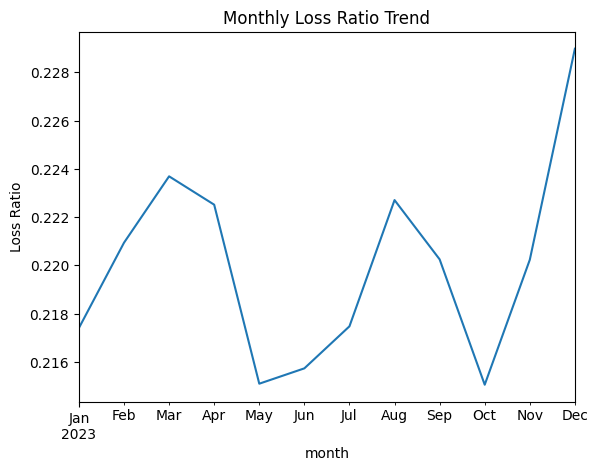

In [9]:
#Loss Ratio Trend
plt.figure()
monthly_kpis["loss_ratio"].plot(kind="line", title="Monthly Loss Ratio Trend")
plt.ylabel("Loss Ratio")
plt.show()


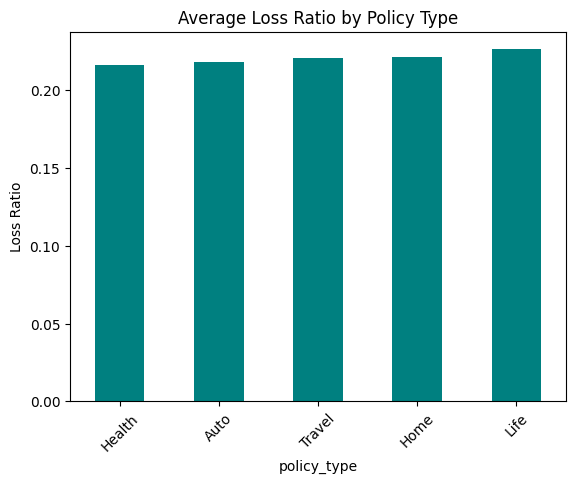

In [15]:
# Loss Ratio by Policy Type
policy_loss = df.groupby("policy_type")["loss_ratio"].mean().sort_values()

plt.figure()
policy_loss.plot(kind="bar", title="Average Loss Ratio by Policy Type", color="teal")
plt.ylabel("Loss Ratio")
plt.xticks(rotation=45)
plt.show()


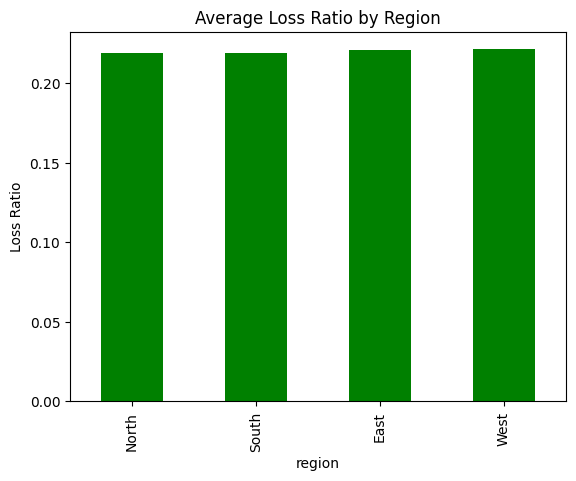

In [18]:
# Regional Loss Ratio Monitoring
region_loss = df.groupby("region")["loss_ratio"].mean().sort_values()

plt.figure()
region_loss.plot(kind="bar", title="Average Loss Ratio by Region",color="green")
plt.ylabel("Loss Ratio")
plt.show()


In [26]:

monthly_kpis["z_score"] = (
    (monthly_kpis["loss_ratio"] - monthly_kpis["loss_ratio"].mean())
    / monthly_kpis["loss_ratio"].std()
)

monthly_kpis["alert_flag"] = monthly_kpis["z_score"].apply(
    lambda x: "ALERT!" if x > 2 else "Normal ✅"
)

alerts = monthly_kpis[monthly_kpis["alert_flag"] == "ALERT!"]

print(alerts)


         premium_collected   claims_paid  avg_csat   avg_nps  fcr_rate  \
month                                                                    
2023-12        32443264.79  7.428812e+06  3.992798  1.395303  0.747554   

         loss_ratio alert_flag   z_score  
month                                     
2023-12    0.228979     ALERT!  2.166205  


In [22]:
# Root Cause Drilldown
high_risk_cases = df[df["loss_ratio"] > 0.9]

print("High Risk Policies Count:", high_risk_cases.shape[0])

high_risk_cases.groupby("policy_type")["claim_amount"].count()


High Risk Policies Count: 518


policy_type
Auto      137
Health    115
Home       59
Life      121
Travel     86
Name: claim_amount, dtype: int64

In [24]:
# Export KPI Reports
monthly_kpis.to_csv("monthly_kpis_report.csv")
alerts.to_csv("loss_ratio_alerts.csv")

print("Reports Exported Successfully!!")


Reports Exported Successfully!!
